# Genome Assembly for Hackers

*This notebook first appeared as a [blog post](//betatim.github.io/posts/genome-hackers) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2016, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

This post collects code snippets I created while learning about genome assembly.
I understand complicated things through code. I build simulations or little
tools and they help me immensely to understand how something works. Probably
because it uses vocabulary I am familiar with (python!) instead of domain
specific jargon.

For another great example of "understanding X through code" check out [Jake VanderPlas'](https://twitter.com/jakevdp) talk [Statistics for hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers) ([video](https://www.youtube.com/watch?v=-7I7MWTX0gA)).

This post covers the basic basics of "genome assembly". Starting with a genome,
creating "reads" from it, breaking these reads up into "kmers", and then
doing the actual assembly. There are a lot of subtleties that I gloss over,
ignored details and ouright shortcuts (hashtag-physics-style). Please biology
friends, don't hate me :)

I assume you have done some reading about this topic and came here to see it
translated into code. I link to various wikipedia articles through out, but
otherwise will not try and explain the biology reasoning behind all this (not just
because I don't know it myself ...).

Let's start with generating a random "genome".

In [1]:
import copy
import string
import random
from itertools import product
from collections import defaultdict

import numpy as np

random.seed(123)
np.random.seed(321)

## The Genome

We will use a fairly short genome made up totally at random. In reality
genomes have millions or billions of base pairs and contain structure.
Welcome to the world of ["spherical cows in a vacuum"](https://en.wikipedia.org/wiki/Spherical_cow).

In [2]:
genome = "".join(random.choice("AGCT") for _ in range(1000))

In [3]:
# this is a great genome, trust me
genome

'ACATCAATCCAGGCCGGATATAACTAAAGGACTTCTACCTGCATTTTCAGATCGCCTATTCAGACACGTACTGTGGTTTAAGTGACCCTTAAACAATATATACCTACTCAGTAGCGAATCGCTCGCAGTTAGTACTTCTAGCGCACGCACGGCCTAAGGAGCGACACGGTTTACTCTGGATCAACTCTCCGTCGGTATTCGTCACACCATATCATCGTCTCGTCCAGAATTGTATGCCGATCACTGACCGTCTAATGGACGGCTTGCAATCGATTTAATTCGTGGGGAGGATAATCAAGTCGCACCGACGTGTGTTGTATACGTAGATCATCCCGTAAACAGTGTGTGAGACAAGGTTGTAAGATAGACTGGGTCGAACCTCGAAAAGCGGACTCCGTACCCACACATGCTAGTAGGCTTCGTACAGGCGAGACAACACCGCTACAACCCTGAAAATTCGGTATGGATGAGCTGTCAAATCAGCCCAGCCGTGTATAGGAGATGTTCAGATACAGAGAATTTCGTTAAAGGGCCTCCTGAAGATGTACCTCCCGGACAATCTGAAGTGATGTCCTCCTGGAAGCAGGGTGGGTATGCCTGATTTCATTACTTAAACCCGTCGAGGTGTTACGCCCACGAAGATTTTAGGCGCTTATACTAGCAACGGAATTTTATAACTTCCCACGAATTCAGCCCGCTCGATGGCGTGCGGTTCTTTCTCATTACTGGAGTTCGCGGTATACTGGCGGCTGGTCGGCGACGTAGGCGCAAGACGAGTTGAAGATGGCGTGCTATCTTGGGGCTGGGGGTAACGATTGGTACCCCGGGGAATCTAGTCATCATAGCCGTTCATTCCAGCCCAAACCTTTGGGGCGTGGTCTGCCTTAGTGGGCTCATCTAGACGCGTGGGGGCTTATTCCGAGTCACGTCTTAAGGTTGATACGGGAAATTCGCTGGGAGCCTCGTCGGGACGCATAACATCAGGCTGTCGCCTCTCCG

## Reading

To get the genome out of a cell you need to read it. This is called [sequencing](https://en.wikipedia.org/wiki/Sequencing). While there are many methods to do
this in an actual lab, in practice they all create "reads". These are short sections
of the genome that cover a random part of it. To start with let's assume we can
generate these reads without making any mistakes.

In [4]:
def perfect_reads(genome, n_reads=10):
    """Create perfect reads from `genome`"""
    starts = np.random.randint(len(genome), size=n_reads)
    length = np.random.randint(27,33, size=n_reads)
    for n in range(n_reads):
        low = starts[n]
        yield genome[low:low + length[n]]

In [5]:
list(perfect_reads(genome, 3))

['GAAGATGTACCTCCCGGACAATCTGAAG',
 'GCAGTTAGTACTTCTAGCGCACGCACG',
 'GGGCTGGGGGTAACGATTGGTACCCCGG']

Reads can vary in size and come without information about where
in the genome they took place. You can end up with duplicate reads
of parts of reads overlapping. This is a good thing. These overlaps
is what will allow us to piece everything back together. Read more
about [Shotgun sequencing](https://en.wikipedia.org/wiki/Shotgun_sequencing)

_NB:_ Today most real world sequencing is done using ["double barrel"
shotguns](https://en.wikipedia.org/wiki/Shotgun_sequencing#Whole_genome_shotgun_sequencing). The key realisation is that you can create reads from both ends of
a fragment of the genome. This way you gain some information about the
direction of the reads relative to each other and how far they are apart.

Next each read is turned into a [`k-mer`](https://en.wikipedia.org/wiki/K-mer).
These are what is used during the actual assembly. `k-mer`s are the substrings of
length `k` that you can generate from a string.

In [6]:
def kmers(read, k=10):
    """Generate `k`-mers from a `read`"""
    for n in range(len(read) - k + 1):
        yield read[n:n+k]

In [7]:
def get_perfect_kmers(genome):
    kmers_ = []
    for read in perfect_reads(genome, n_reads=1000):
        for kmer in kmers(read):
            kmers_.append(kmer)
            
    return kmers_

In [8]:
kmers_ = get_perfect_kmers(genome)
# lots of kmers, but not that many are unique
print(len(kmers_), len(set(kmers_)))

19968 990


With perfect reads from our random genome you end up with a
large number of `k-mers` (of length ten) but most of them
are duplicates. The roughly 20000 `k-mers` we created only
contain about 1000 unique `k-mers`.


## Flipping reads

In reality the sequencing process is not perfect and will
make mistakes. The simplest way to illustrate this is to
randomly flip a base in a read. Even fairly low error rates
of 1% per base have a large effect on the number of unique `k-mers`
we find.

In [9]:
def flip(read, p=0.01):
    """Flip a base to one of the other bases with probability `p`"""
    bases = []
    for b in read:
        if np.random.uniform() <= p:
            bases.append(random.choice("AGCT".replace(b, "")))
        else:
            bases.append(b)
    return "".join(bases)

def reads_with_errors(genome, n_reads=10):
    """Generate reads where bases might be flipped."""
    starts = np.random.randint(len(genome), size=n_reads)
    length = np.random.randint(27,33, size=n_reads)
    for n in range(n_reads):
        low = starts[n]
        yield flip(genome[low:low + length[n]])

In [10]:
def get_kmers(genome):
    kmers_ = []
    for read in reads_with_errors(genome, n_reads=1000):
        for kmer in kmers(read):
            kmers_.append(kmer)
            
    return kmers_

kmers_ = get_kmers(genome)
# roughly same number of kmers, but a lot more unique ones
print(len(kmers_), len(set(kmers_)))

20055 3062


We still generate roughly 20000 `k-mers` but now there are
three times as many unique `k-mers`. This is one of the factors
that makes assembling a genome so hard.

So now that we have a super simplistic model for generating
`k-mers`, how do we put them back together?

# Assembly

Left as an exercise for the reader.

Just kidding. Assembly happens by creating
a [de Bruijn graph](https://en.wikipedia.org/wiki/De_Bruijn_graph)
from our `k-mers`. Importantly each `k-mer` is represented
by an **edge** in the graph, not a node! Nodes are for `k-1-mers`.
If we have one 4-mer, `abcd`, the graph would look like this: `abc -> bcd`.
The first node represents the first `n-1` symbols in the `k-mer` and
the second node represents the last `n-1` symbols.

We will leave the world of biology behind for a moment and create
completely artificial examples. I found this easier to understand
and debug.

First we will need something that can turn a string into a graph.
Using `k=2` the `make_graph` function will do just that.

In [11]:
def make_graph(string, k):
    k_mers = list(kmers(string, k))
    nodes = defaultdict(list)

    for kmer in k_mers:
        head = kmer[:-1]
        tail = kmer[1:]
        nodes[head].append(tail)
        
    return nodes

nodes = make_graph('abcbdexdbfga', 2)
print(nodes)

defaultdict(<class 'list'>, {'b': ['c', 'd', 'f'], 'c': ['b'], 'x': ['d'], 'f': ['g'], 'd': ['e', 'b'], 'g': ['a'], 'a': ['b'], 'e': ['x']})


`nodes` is a dictionary mapping each node to the list
of outgoing edges for that node. Its printed representation
is quite ugly, so here is a graphical version of it:

<img src="/images/euler-graph.png"/>

You can render this with `graphviz` but this is not
installed on tmpbnb.org so will fail here.

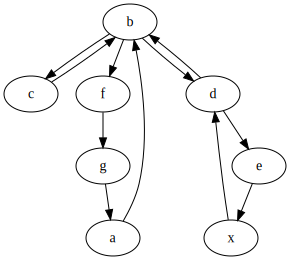

In [12]:
from graphviz import Digraph

dot = Digraph(comment='debruijn')

for km1mer in nodes:
    dot.node(km1mer, km1mer)
    
for src in nodes:
    ends = nodes[src]
    for end in ends:
        dot.edge(src, end)

dot.format = 'png'
dot

## Eulerian walks

Why create this weird graph structure from our reads? At
first it seems like it makes things more complicated. Actually
this is an example of transforming your problem to make it
easier.

To reconstruct the original string from this graph all we
have to do is find a trip along all the edges of the graph
that visits each edge only once. If we can do that, we
are done. People who are into graph theory call this
an eulerian walk. If you grew up in Germany you might
recognise this as solving the [kids puzzle](https://de.wikipedia.org/wiki/Haus_vom_Nikolaus) "Das ist das
Haus vom Ni-ko-laus."


<p><a href="https://commons.wikimedia.org/wiki/File:Blender3D_HouseOfStNiclas.gif#/media/File:Blender3D_HouseOfStNiclas.gif"><img src="https://upload.wikimedia.org/wikipedia/commons/1/11/Blender3D_HouseOfStNiclas.gif" alt="Blender3D HouseOfStNiclas.gif"></a><br>Von <a href="//commons.wikimedia.org/wiki/User:SoylentGreen" title="User:SoylentGreen">SoylentGreen</a> - <span class="int-own-work" lang="de">Eigenes Werk</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, https://commons.wikimedia.org/w/index.php?curid=2308144</p>


## Is it a tour?

First things first, how will we know if a proposed tour is
a valid one? This is what the next few functions take care
of.

In [13]:
def edges(graph):
    """List all directed edges of `graph`"""
    for node in graph:
        for target in graph[node]:
            yield (node, target)


def follow_tour(tour, graph):
    """Follow a tour and check it is eulerian"""
    edges_ = list(edges(graph))
    for start, end in zip(tour, tour[1:]):
        try:
            edges_.remove((start, end))
        # most likely removing an edge that was already used
        except:
            return False
        
    # if there are any edges left this is neither
    # an eulerian tour nor an eulerian trail
    if edges_:
        return False
    else:
        return True


def check_tour(start, graph):
    our_tour = tour(start, graph)
    valid_tour = follow_tour(our_tour, graph)
    return valid_tour, "".join(s[0] for s in our_tour) 

To construct an actual eulerian cycle or trail we use
[Hierholzer's algorithm](https://en.wikipedia.org/wiki/Eulerian_path#Hierholzer.27s_algorithm).

There are some subtleties we would have to take
care of for a production grade implementation, like
dealing with where to start when the graph only contains
an eulerian path and not a cycle, etc. However it
does the job for small examples and allows you to
witness the miracle of genome assembly!

In [14]:
def tour(start_node, graph):
    """Find an eulerian cycle or trail.
    
    This does not check if the graph is eulerian
    so it might return tours that are nonsense.
    """
    # _tour() modifies the graph structure so we need to copy it
    graph = copy.deepcopy(graph)
    return _tour(start_node, graph)

def _tour(start_node, graph, end=None):
    tour = [start_node]
    finish_on = end if end is not None else start_node
    while True:
        options = graph[tour[-1]]

        # eulerian trail, not tour?
        if not options:
            break
        
        tour.append(options.pop())
        if tour[-1] == finish_on:
            break
    
    # when we insert a sub-tour we extend the
    # length of tour, need to track this
    offset = 0
    for n,step in enumerate(tour[:]):
        options = graph[step]
        if options:
            t = _tour(options.pop(), graph, step)
            n += offset
            tour = tour[:n+1] + t + tour[n+1:]
            offset += len(t)
            
    return tour

below some examples of graphs I tried out while
writing the algorithm. This is an [interactive blog post](http://betatim.github.io/posts/interactive-posts/)
so play around with them. Use the snippet form above to
draw each graph if you prefer to see it visually.

In [15]:
check_tour('a', {'a': ['b'], 'b': ['a']})
check_tour('a', {'a': ['b'], 'b': ['c'], 'c': ['a', 'e'], 'e': ['f'], 'f': ['c']})
check_tour('a', {'a': ['b'], 'b': ['c'], 'c': ['a', 'e'], 'e': ['f'],
                 'f': ['c', 'g'], 'g': ['f']})
check_tour('f', {'a': ['b'], 'b': ['c'], 'c': ['a', 'e'], 'e': ['f'],
                 'f': ['c', 'g'], 'g': ['f']})
check_tour('g', {'a': ['b'], 'b': ['c'], 'c': ['a', 'e'], 'e': ['f'],
                 'f': ['c', 'g'], 'g': ['f']})
check_tour('c', {'a': ['b'], 'b': ['c'], 'c': ['a', 'e'], 'e': ['f'],
                 'f': ['c', 'g'], 'g': ['f']})


random.seed(54)
genome = 'abcbdexdbfga'
g = make_graph(genome, 2)

valid, t = check_tour(genome[random.randint(0, len(genome)-1)], g)

print(g)
print(t)

defaultdict(<class 'list'>, {'b': ['c', 'd', 'f'], 'c': ['b'], 'x': ['d'], 'f': ['g'], 'd': ['e', 'b'], 'g': ['a'], 'a': ['b'], 'e': ['x']})
cbfgabdexdbc


I hope this helps you understand a bit more how all this genome assembly
stuff works. it certainly helped me. If you know about the biology behind
all this, please be lenient, if you spot gross mistakes or imprecise
statements that cause confusion for novices do get in touch!

If you find a mistake or want to tell me something else get in touch on twitter @[betatim](//twitter.com/betatim)